In [75]:
random_state = 123

In [76]:
import sys
import os

# Add the root directory of your project to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src import imputation as imp, visualization as viz, modelling as ml

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score, auc, make_scorer, log_loss, accuracy_score, classification_report


In [77]:
penguins_raw = pd.read_csv("../data/penguins_raw.csv")

### Initial Exploration

#### Data Types

In [78]:
penguins_raw.dtypes

studyName               object
Sample Number            int64
Species                 object
Region                  object
Island                  object
Stage                   object
Individual ID           object
Clutch Completion       object
Date Egg                object
Culmen Length (mm)     float64
Culmen Depth (mm)      float64
Flipper Length (mm)    float64
Body Mass (g)          float64
Sex                     object
Delta 15 N (o/oo)      float64
Delta 13 C (o/oo)      float64
Comments                object
dtype: object

#### Normalize columns

In [79]:
penguins_raw.columns = map(lambda x: str(x).lower().replace(" ","_").replace("(", "").replace(")", "").replace("/", "_"), penguins_raw.columns)


#### Head

In [80]:
penguins_raw.head(5) 

## We can already see some NaN and we should definetely convert Date Egg to date type. 
## Some NAs look very important like the Sex NaN in the 4th row.
## Retrieving information of the comments columns might be a challenge
## The objective variable will be species and we can ommit sample number/Individual ID as it is not relevant and will not help as generalize
## We shall omit those observation which do not have measures like 4th.


,studyname,sample_number,species,region,island,stage,individual_id,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


#### Missing values

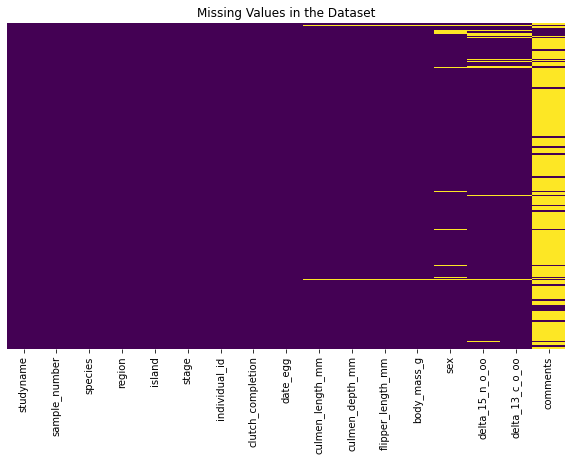

In [81]:
# Plot missing values as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(penguins_raw.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values in the Dataset')
plt.show()

## There are 2 observations where we dont have multiple variables, in Sex we have mutiples instances where we do not have values and the variables delta 15 and 13 share almost all the same missings.
## Comments was to be expected that it would be like this

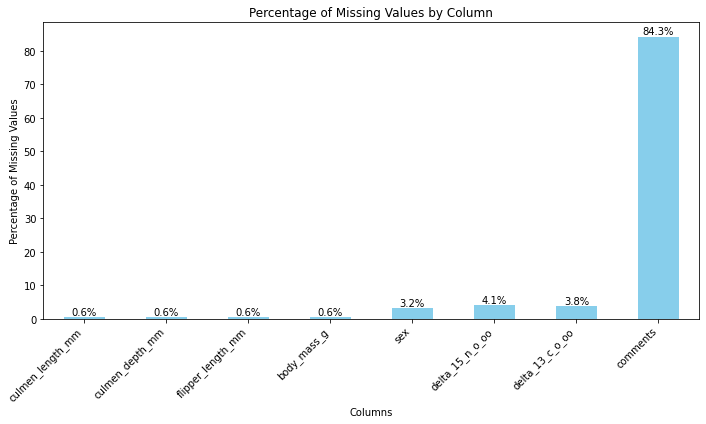

In [82]:
viz.plot_missing_values_greater_than_0(df=penguins_raw)

#### Drop unused variables

In [83]:
penguins_raw.columns

Index(['studyname', 'sample_number', 'species', 'region', 'island', 'stage',
       'individual_id', 'clutch_completion', 'date_egg', 'culmen_length_mm',
       'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex',
       'delta_15_n_o_oo', 'delta_13_c_o_oo', 'comments'],
      dtype='object')

In [84]:
pgs_wo_unnnecesary_cols = penguins_raw.drop(['studyname', 'sample_number', 'individual_id'],axis=1)

#### Convert to date necesary columns

In [85]:
pgs_wo_unnnecesary_cols['date_egg'] = pd.to_datetime(pgs_wo_unnnecesary_cols['date_egg'])

### EDA

#### Univariate distributions

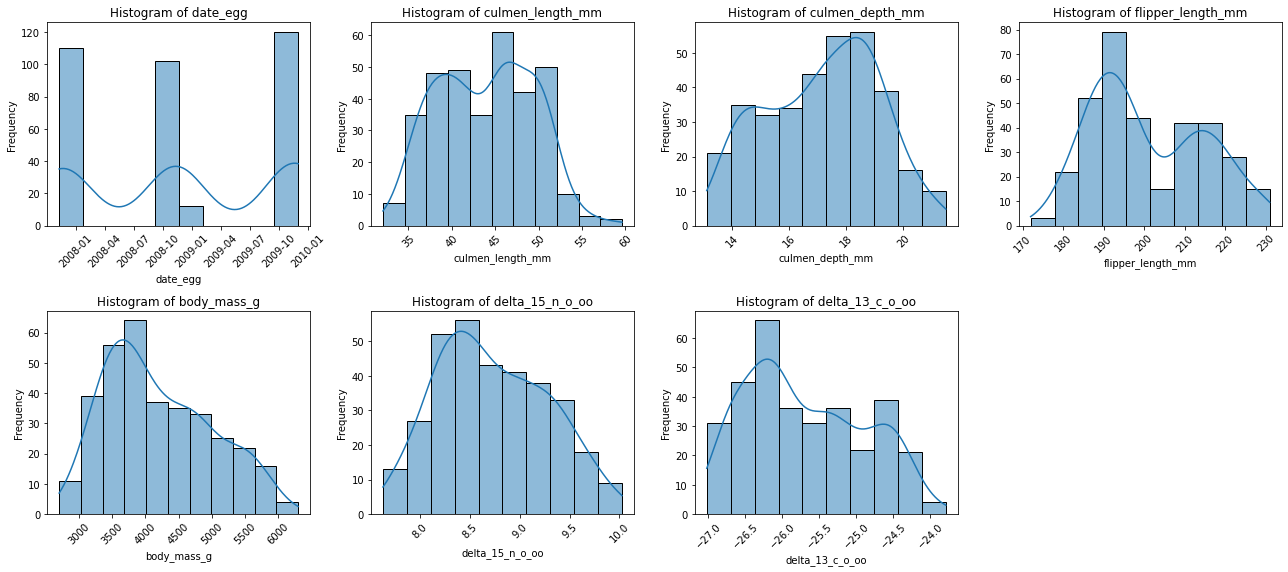

In [86]:
viz.create_numeric_eda(pgs_wo_unnnecesary_cols, graphs_per_row=4, fig_height=4)

## The date egg column looks like it is more of a factor columna with 3-4 levels rather than a continuos date
## The rest of the columns have no extreme outliers so the data is pretty standardized from the beginning. 

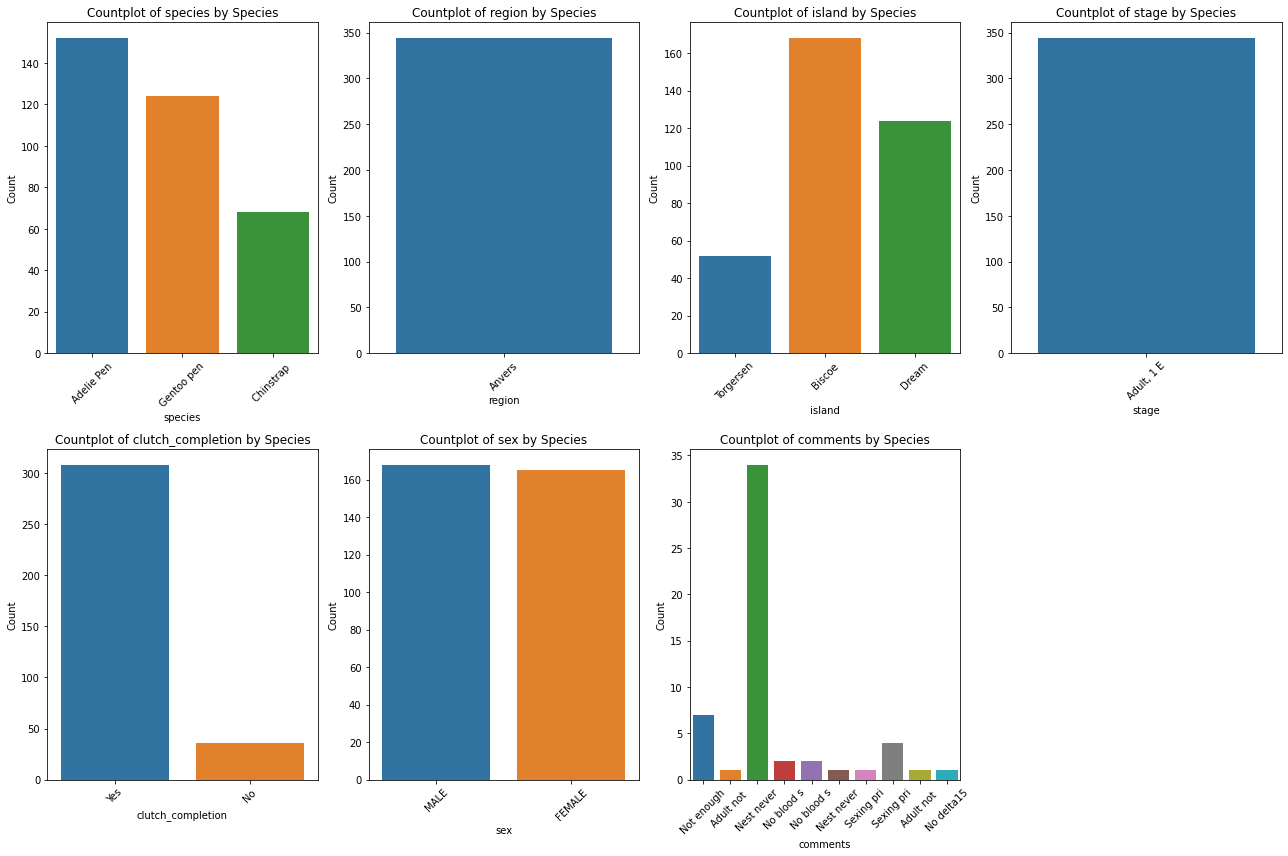

In [87]:
viz.create_factor_eda(pgs_wo_unnnecesary_cols, graphs_per_row=4, fig_height=6, abbreviate_names=True)
## We can see that the target variable is not perfectly balance, although it is not very skewed to any particular species
## The Biscoe island is the one with more instances and Torgersen with the least. The Clutch Completion is mostly Yes.

## It looks like the comments is the argument of why some variable is missing its value. 

#### Droping extra columns

In [88]:
## After revising the EDA there are two factors which are useless so we remove them

pgs_wo_unnnecesary_cols = pgs_wo_unnnecesary_cols.drop(['region', 'stage'],axis=1)


#### Bi-variate distributions

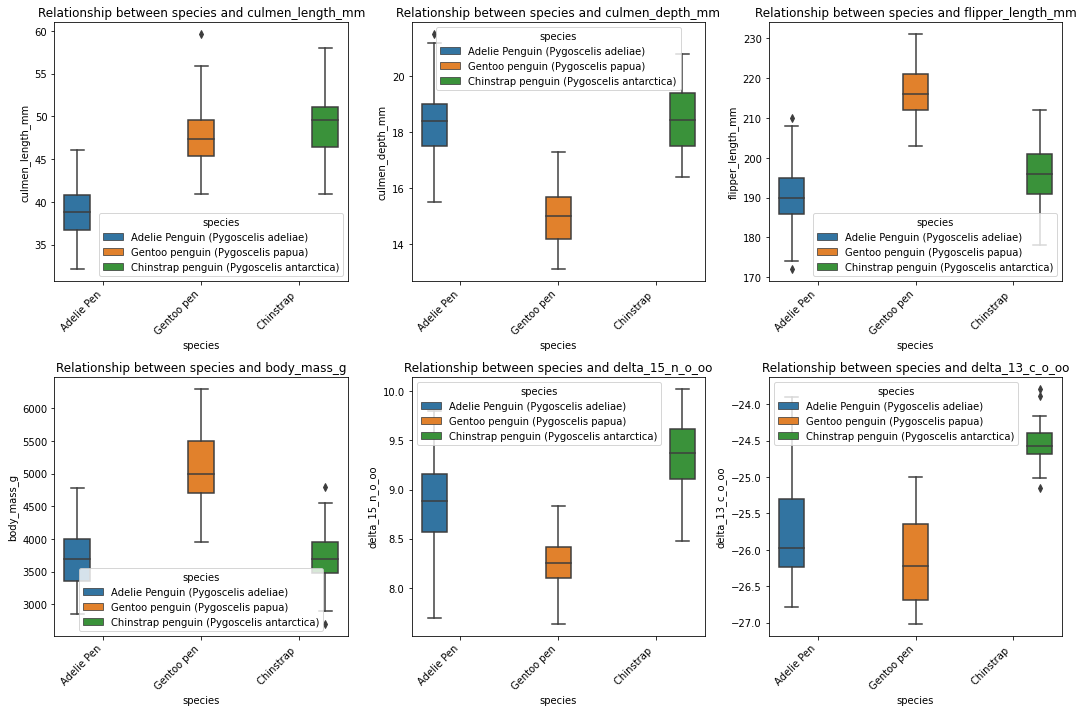

In [89]:
viz.bivariate_w_target_variable(data=pgs_wo_unnnecesary_cols, numeric_vars=True, target='species', ncols=3, fig_width=15, fig_height_per_row=5)

## The numerical variables have very identifiable clusters in which we can relate some characteristics of the penguin with the exact species. 

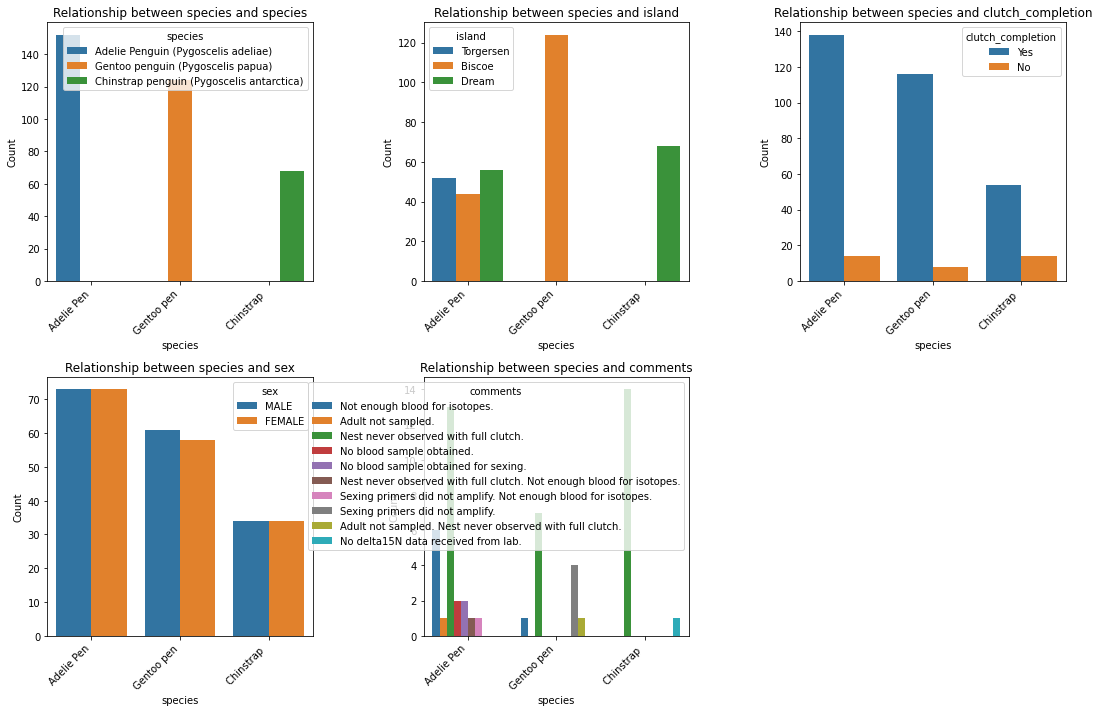

In [90]:
viz.bivariate_w_target_variable(data=pgs_wo_unnnecesary_cols, numeric_vars=False, target='species', ncols=3, fig_width=15, fig_height_per_row=5)
## There are islands with only one type of penguin, therefore the data will be highly skewed if we include this data.
## We can make two choices: delete the variable island or continue as it is a relevant feature to take into account. 
## We should take into account the objective of this study if we need to spot species in only these islands or we will like the model to generalize in others regions.
## We will take the latter as it is the most conservative one. 

#### Droping island column

In [91]:
## After revising the EDA there are two factors which are useless so we remove them

pgs_wo_island_col = pgs_wo_unnnecesary_cols.drop(['island'],axis=1)


### Preprocessing

#### Missings and splitting

In [92]:
## We will drop those instances that have missing values in culmen_length_mm, culmen_depth_mm, flipper_length_mm 
## as they are only two observations and we don't loose much information and the comments shows us the reason why.
pgs_drp_na_clm = pgs_wo_island_col.dropna(subset=['culmen_length_mm'])


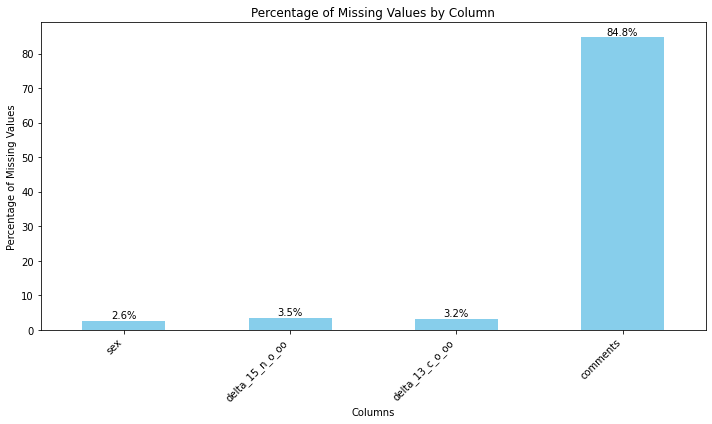

In [93]:
viz.plot_missing_values_greater_than_0(df=pgs_drp_na_clm)

In [94]:
## We will discard the target variable for the imputation and split the dataset into train, test and validation now. So we also test the imputation algorithm. 

y = pgs_drp_na_clm[['species']]
x_impute = pgs_drp_na_clm.drop('species', axis=1)



Splitting data into train, test and validation sets

In [95]:
# Split data into train and temp sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(x_impute, y, test_size=0.3,random_state=random_state) ## We add random state in order to be able to reproduce our results

# # Split temp data into test and validation sets (50% test, 50% validation)
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state) ## We add random state in order to be able to reproduce our results

In [96]:
print("Shape of train: ", X_train.shape)
# print("Shape of validatio: ", X_val.shape)
print("Shape of test: ", X_test.shape)

Shape of train:  (239, 10)
Shape of test:  (103, 10)


KNN - Imputation

In [97]:
X_train = X_train.drop(columns=['date_egg', 'comments'])
X_test = X_test.drop(columns=['date_egg', 'comments'])
# X_val = X_val.drop(columns=['date_egg', 'comments'])

In [98]:
## The rest of the variables will be imputed with K-NN for the sex and random forest for delta_15... and delta_13

knn_imputer_sex = imp.imputation_knn(X_train, X_test, 'sex')

Random Forest - Imputation: The intention is to impute non-target columns using the mean before applying the RandomForest imputer to the target columns.


In [99]:
print(X_train.isnull().sum())

simple_imputer = SimpleImputer(strategy='mean')

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()
# X_val_imputed = X_val.copy()


X_train_imputed['delta_15_n_o_oo'] = simple_imputer.fit_transform(X_train[['delta_15_n_o_oo']])
X_test_imputed['delta_15_n_o_oo'] = simple_imputer.fit_transform(X_test[['delta_15_n_o_oo']])
# X_val_imputed['delta_15_n_o_oo'] = simple_imputer.fit_transform(X_val[['delta_15_n_o_oo']])


imp.imputation_random_forest(X_train_imputed, X_test_imputed, 'delta_13_c_o_oo')

X_train['delta_13_c_o_oo'] = X_train_imputed['delta_13_c_o_oo']
X_test['delta_13_c_o_oo'] = X_test_imputed['delta_13_c_o_oo']


imp.imputation_random_forest(X_train, X_test, 'delta_15_n_o_oo')


clutch_completion    0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
delta_15_n_o_oo      7
delta_13_c_o_oo      7
dtype: int64


#### One Hot encoding

In [100]:
object_cols = X_train.select_dtypes(include=['object']).columns
X_train_encoded = pd.get_dummies(X_train, columns=object_cols)
X_test_encoded = pd.get_dummies(X_test, columns=object_cols)
# X_val_encoded = pd.get_dummies(X_val, columns=object_cols)


In [101]:
try: 
    X_test_encoded = X_test_encoded.drop(["sex_nan"],axis=1)
    X_train_encoded = X_train_encoded.drop(["sex_nan"],axis=1)
    # X_val_encoded = X_val_encoded.drop(["sex_nan"],axis=1)
except: print("No change")

### Modelling

**First Validation: K-fold Cross Validation**

In [102]:
# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(kernel='rbf', probability=True),
    'Linear SVM': SVC(kernel='linear', probability=True)
}

# Define the cross-validation method
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the scoring metric
scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Perform cross-validation for each model
results = {}
for name, model in models.items():
    cv_results = cross_val_score(model, X_train_encoded, y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    print(f'{name}: {cv_results.mean()} ({cv_results.std()})')

# Summary of cross-validation results
for name, cv_results in results.items():
    print(f'Model: {name}')
    print(f'Mean Log-loss: {np.mean(cv_results)}')
    print(f'Standard Deviation: {np.std(cv_results)}')
    print('-'*30)

c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataC

Logistic Regression: -0.014118618408817818 (0.01277817273368665)
K-Nearest Neighbors: -1.4069711937931704 (1.0942172197054016)


c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\inigo\AppData\Local\Programs\Py

Random Forest: -0.07113479050702902 (0.03948886747668351)
SVM: -0.514692328804436 (0.05786827994404047)


c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataC

Linear SVM: -0.04910981203484489 (0.016097250513206825)
Model: Logistic Regression
Mean Log-loss: -0.014118618408817818
Standard Deviation: 0.01277817273368665
------------------------------
Model: K-Nearest Neighbors
Mean Log-loss: -1.4069711937931704
Standard Deviation: 1.0942172197054016
------------------------------
Model: Random Forest
Mean Log-loss: -0.07113479050702902
Standard Deviation: 0.03948886747668351
------------------------------
Model: SVM
Mean Log-loss: -0.514692328804436
Standard Deviation: 0.05786827994404047
------------------------------
Model: Linear SVM
Mean Log-loss: -0.04910981203484489
Standard Deviation: 0.016097250513206825
------------------------------


**Second Validation: Hyper-parameter tuning**

In [103]:
kfold = 5

## Logistic Regression
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'tol': [1e-4, 1e-3, 1e-2],
    'solver': ['lbfgs'],
    'multi_class': ['multinomial'],
    'max_iter': [200]
}

# Perform grid search
grid_search_lr = GridSearchCV(LogisticRegression(multi_class="multinomial", random_state=random_state), param_grid_lr, cv=kfold, scoring='neg_log_loss')
grid_search_lr.fit(X_train_encoded, y_train)

# Best parameters and score
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best log-loss for Logistic Regression:", grid_search_lr.best_score_)

# Best parameters for Logistic Regression: {'C': 1, 'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001}
# Best log-loss for Logistic Regression: -0.0020830913434287243

c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed w

Best parameters for Logistic Regression: {'C': 100, 'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001}
Best log-loss for Logistic Regression: -0.0020830913434287243


c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (st

**Train** the final model with the best hyperparameters and the entire data

c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\inigo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


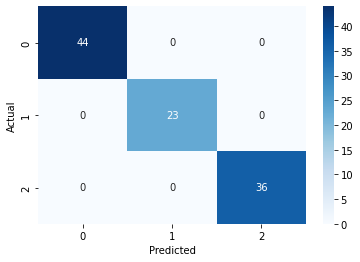

In [104]:
# Best parameters found for SVC with Linear kernel:  {'C': 1, 'tol': 0.001}
# Best parameters for Logistic Regression: {'C': 100, 'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001}

best_params_lr = {
    'C': 1,
    'max_iter': 200,
    'multi_class': 'multinomial',
    'solver': 'lbfgs',
    'tol': 0.0001
}

# Crear la instancia del modelo con los mejores parámetros
lr = LogisticRegression(**best_params_lr, random_state=random_state)
ml.evaluate_model(model=lr, X_train=X_train_encoded, y_train=y_train, X_test=X_test_encoded, y_test=y_test)

**Feature importance**

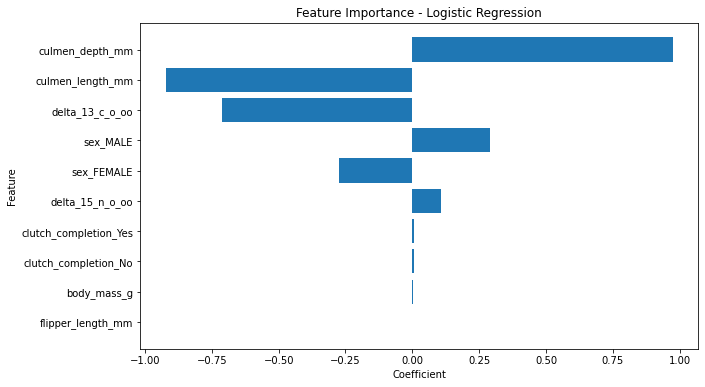

In [105]:
feature_names = X_train_encoded.columns

coefficients = lr.coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].apply(np.abs)
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

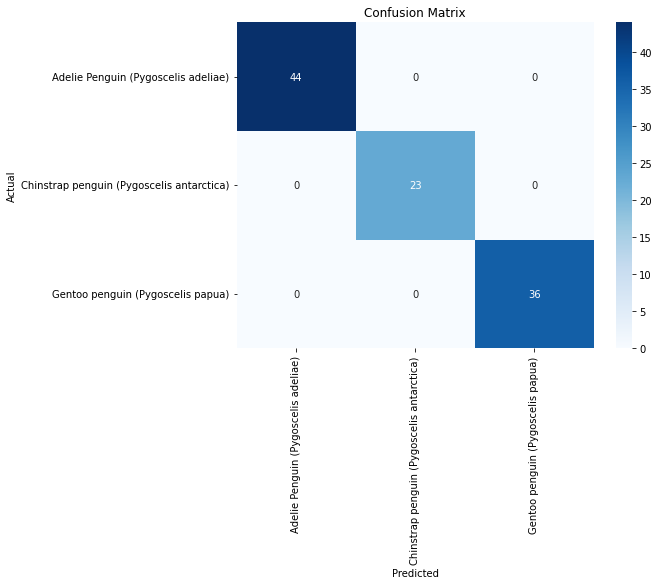

Classification Report:
                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       1.00      1.00      1.00        44
Chinstrap penguin (Pygoscelis antarctica)       1.00      1.00      1.00        23
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        36

                                 accuracy                           1.00       103
                                macro avg       1.00      1.00      1.00       103
                             weighted avg       1.00      1.00      1.00       103

Accuracy: 1.0
Log-Loss: 0.020684172119767894
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [106]:
y_pred = lr.predict(X_test_encoded)
y_pred_proba = lr.predict_proba(X_test_encoded)

conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
log_loss_score = log_loss(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

classification_report_str = classification_report(y_test, y_pred, target_names=lr.classes_)
print('Classification Report:')
print(classification_report_str)

print(f'Accuracy: {accuracy}')
print(f'Log-Loss: {log_loss_score}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


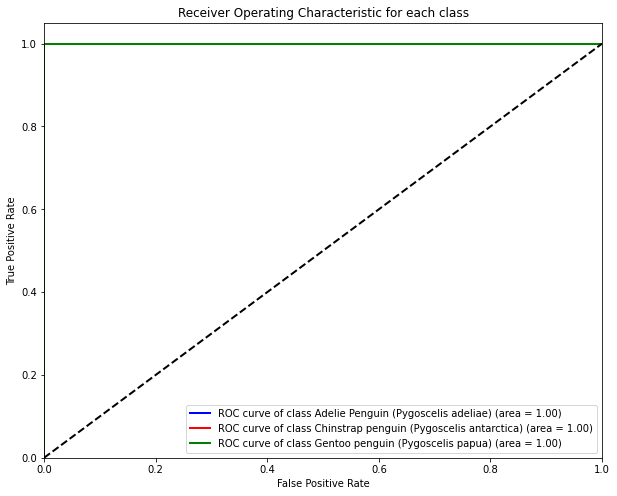

In [107]:
# ROC Curve

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(lr.classes_)  # Número de clases

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == lr.classes_[i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(lr.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()
